In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import optuna.integration.lightgbm as lgb
import optuna

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

In [3]:
data = pd.read_excel('./data/data.xlsx')

In [4]:
data

,CoilNO,제품종류,제품Size,압연시작일시,압연완료일시,Descaler.No1_Pressure,Descaler.No2_Pressure,조압연입측소재온도,조압연입측소재온도.1,중간사상압연_No2_출측소재온도,...,Middle.Cooling Zone#4(4WB)유량,Middle.Cooling Zone#4(4WB)압력,Last.Cooling Zone#1(1WB)유량,Last.Cooling Zone#1(1WB)압력,Last.Cooling Zone#2(2WB)유량,Last.Cooling Zone#2(2WB)압력,Rolling Time,Idle Time,압연 Pitch,선재사상압연모터전류
0,Q540024003,Product_17,7.0,2016-01-01 05:56:00,2016-01-01 06:00:00,243,142,1065,0,1030,...,410.9,1.0,584.2,1.0,593.2,1.6,67,7,74,704.610300
1,Q540027003,Product_17,7.0,2016-01-01 05:57:00,2016-01-01 06:02:00,253,143,1062,0,1024,...,401.8,1.0,581.2,1.0,584.7,1.6,67,7,74,709.257700
2,Q540030003,Product_17,7.0,2016-01-01 05:59:00,2016-01-01 06:03:00,225,141,1061,0,1029,...,395.2,0.9,581.7,1.0,582.2,1.6,67,8,75,725.786700
3,Q540033003,Product_17,7.0,2016-01-01 06:00:00,2016-01-01 06:04:00,235,143,1064,0,1024,...,400.6,1.0,580.4,1.0,583.4,1.6,67,11,78,717.851033
4,Q540036003,Product_17,7.0,2016-01-01 06:01:00,2016-01-01 06:05:00,251,142,1061,0,1025,...,348.9,0.7,580.6,1.0,581.8,1.6,67,8,75,699.787467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100464,B19284069006,Product_22,21.0,2016-12-31 13:22:00,2016-12-31 13:25:00,259,0,890,943,954,...,53.3,0.0,61.4,0.0,53.2,0.0,45,300,345,468.775600
100465,B19284069003,Product_22,21.0,2016-12-31 13:40:00,2016-12-31 13:44:00,261,0,869,941,956,...,53.5,0.0,68.8,0.0,56.2,0.0,44,300,344,469.696400
100466,B19284069012,Product_22,21.0,2016-12-31 13:56:00,2016-12-31 13:59:00,261,0,864,946,957,...,53.0,0.0,65.1,0.0,54.4,0.0,44,300,344,470.485533
100467,B19284069015,Product_22,21.0,2016-12-31 14:08:00,2016-12-31 14:11:00,259,0,865,952,966,...,53.0,0.0,64.2,0.0,52.6,0.0,41,300,341,470.617100


In [5]:
data.columns
# data = data[data['제품종류'] == 'Product_17'] # 제품별

Index(['CoilNO', '제품종류', '제품Size', '압연시작일시', '압연완료일시', 'Descaler.No1_Pressure',
       'Descaler.No2_Pressure', '조압연입측소재온도', '조압연입측소재온도.1',
       '중간사상압연_No2_출측소재온도', '선재사상압연입측소재온도', '선재사상압연출측소재온도', '최종압연 입측소재온도',
       '선재 Wire Rod 인출장치 출측소재온도', '조압연입측속도', '조압연출측속도', '중간압연1출측속도',
       '중간압연2출측속도', '중간사상압연_No2_출측속도', '선재사상압연출측속도', '최종압연 출측속도',
       '선재 Wire Rod 인출장치 진입속도', 'First.Cooling Zone#1(1WB)유량',
       'First.Cooling Zone#1(1WB)압력', 'First.Cooling Zone#2(2WB)유량',
       'First.Cooling Zone#2(2WB)압력', 'Middle.Cooling Zone#1(1WB)유량',
       'Middle.Cooling Zone#1(1WB)압력', 'Middle.Cooling Zone#2(2WB)유량',
       'Middle.Cooling Zone#2(2WB)압력', 'Middle.Cooling Zone#3(3WB)유량',
       'Middle.Cooling Zone#3(3WB)압력', 'Middle.Cooling Zone#4(4WB)유량',
       'Middle.Cooling Zone#4(4WB)압력', 'Last.Cooling Zone#1(1WB)유량',
       'Last.Cooling Zone#1(1WB)압력', 'Last.Cooling Zone#2(2WB)유량',
       'Last.Cooling Zone#2(2WB)압력', 'Rolling Time', 'Idle Time', '압연 Pitch',
       '선재사상압연모터전류'],

In [72]:
y = data['선재사상압연모터전류'].values
data['압연시간'] = (data['압연완료일시'] - data['압연시작일시']).dt.seconds
data['제품종류'] = data['제품종류'].str.extract('(\d+)').astype('category')

KeyError: '선재사상압연모터전류'

In [7]:
data.drop(['CoilNO', '선재사상압연모터전류', '압연완료일시', '압연시작일시'], inplace=True, axis=1)
x = data.values

In [8]:
scaler = StandardScaler()

In [9]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)

In [10]:
train_product_type = train_x['제품종류']
text_product_type = test_x['제품종류']

train_x = pd.DataFrame(scaler.fit_transform(train_x), columns=data.columns)
test_x = pd.DataFrame(scaler.transform(test_x), columns=data.columns)
train_x['제품종류'] = train_product_type
test_x['제품종류'] = text_product_type

In [11]:
test_x

,제품종류,제품Size,Descaler.No1_Pressure,Descaler.No2_Pressure,조압연입측소재온도,조압연입측소재온도.1,중간사상압연_No2_출측소재온도,선재사상압연입측소재온도,선재사상압연출측소재온도,최종압연 입측소재온도,...,Middle.Cooling Zone#4(4WB)유량,Middle.Cooling Zone#4(4WB)압력,Last.Cooling Zone#1(1WB)유량,Last.Cooling Zone#1(1WB)압력,Last.Cooling Zone#2(2WB)유량,Last.Cooling Zone#2(2WB)압력,Rolling Time,Idle Time,압연 Pitch,압연시간
0,1.730748,-1.309476,0.346066,-0.792489,-0.533662,0.590704,-1.324844,-3.362637,-4.890131,0.051631,...,0.476901,1.532773,-1.018232,-0.878475,-0.866920,-0.605322,1.971952,-0.226746,0.501730,1.132776
1,1.249877,1.628616,0.062086,1.308464,-3.028946,-1.246314,-0.565790,0.248432,-0.370902,-0.906202,...,-1.481536,-0.932121,-2.193603,-2.043499,-2.233953,-1.869804,-0.569902,-0.279875,-0.464364,-0.046618
2,1.442226,-0.251763,-0.108302,-0.792489,1.064879,0.884301,0.680203,2.346039,0.308492,-0.035445,...,1.187678,1.121957,1.199348,1.888457,1.100777,1.670747,-0.569902,-0.209036,-0.398866,-0.046618
3,2.115445,1.863663,0.800435,-0.792489,-2.619564,-1.246314,-0.494182,0.407744,-0.375935,-0.906202,...,-1.282161,-0.932121,-1.629840,0.286549,-1.561953,0.406264,-0.569902,-0.297585,-0.480738,-0.046618
4,-0.096561,1.158521,1.084415,-0.792489,0.382575,-1.246314,0.365124,0.168776,-0.109210,0.109681,...,-0.700128,-0.726713,0.528675,-0.004707,0.702497,-0.352425,-0.569902,-0.315295,-0.497112,-0.046618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20089,-0.385083,-0.251763,-0.846651,1.572655,0.460552,-1.246314,0.551307,0.195328,0.102157,-0.180571,...,0.082173,-0.110490,0.697402,0.869061,0.339103,0.279816,-0.615292,-0.315295,-0.513487,-1.226012
20090,1.442226,0.923474,0.232474,-0.792489,-0.728606,-1.246314,-0.064529,0.752920,0.011571,-0.006420,...,-0.225830,-0.521305,1.418036,1.597201,1.591416,0.785609,-0.615292,-0.297585,-0.497112,-0.046618
20091,-1.154476,-1.074429,-0.108302,-0.792489,1.220834,0.784397,0.293516,0.062568,0.509794,0.225782,...,0.215835,1.532773,0.705658,-0.441591,0.886319,-0.352425,0.519464,-0.315295,-0.104125,-0.046618
20092,-0.385083,-1.309476,-0.221894,1.459430,0.324092,-1.246314,-0.694686,0.036016,0.373915,-0.354722,...,0.225670,-0.521305,-0.958744,-0.441591,-0.399091,-0.605322,1.881172,-0.315295,0.387108,1.132776


In [12]:
categorical_features = [c for c, col in enumerate(data.columns) if '제품종류' in col]

In [33]:
train_ds = lgb.Dataset(train_x, label = train_y, categorical_feature = categorical_features) 
test_ds = lgb.Dataset(test_x, label = test_y, categorical_feature = categorical_features) 

TypeError: __init__() got an unexpected keyword argument 'feature_pre_filter'

In [14]:
# tuner
params = {'objective': 'regression', 
          'metric': 'l2', 
          'verbosity': -1, 
          'boosting_type': 
          'gbdt', 'seed': 42, 
          'lambda_l1': 1.8181610459903688, 
          'lambda_l2': 3.036195578064946e-07, 
          'num_leaves': 450, 
          'feature_fraction': 0.5823535263763776, 
          'bagging_fraction': 0.9968221969358954, 
          'bagging_freq': 12, 
          'min_child_samples': 91,
          'seed' : 2018}

----
----
----

In [ ]:
# model = lgb.train(params, train_ds, 10000, test_ds, verbose_eval=100, early_stopping_rounds=100)

In [ ]:
# predict_train = model.predict(train_x)
# predict_test = model.predict(test_x)

In [ ]:
# mse = mean_squared_error(test_y, predict_test)
# r2 = r2_score(test_y, predict_test)

In [ ]:
# print('Mean squared error: ', mse)
# print('R2 score: ', r2)

In [ ]:
# final_result = pd.concat([pd.DataFrame(test_y), pd.DataFrame(predict_test)], axis = 1)

In [ ]:
# final_result.columns = ['label','predict']

In [ ]:
# sns.regplot(x = 'label', y = 'predict', data = final_result)

In [ ]:
# ax = lgb.plot_importance(model, max_num_features=len(data.columns), importance_type='split', figsize=(15,15))
# ax.set(title=f'Feature Importance (split)',
# 	xlabel='Feature Importance',
# 	ylabel='Features')

In [ ]:
# ax = lgb.plot_importance(model, max_num_features=len(data.columns), importance_type='gain', figsize=(15,15))
# ax.set(title=f'Feature Importance (gain)',
# 	xlabel='Feature Importance',
# 	ylabel='Features')

In [ ]:
# import shap

In [ ]:
# shap.initjs()
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(test_x)
# fig = shap.summary_plot(shap_values, test_x)

----
----
----

In [14]:
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
kf = KFold(n_splits=5)

params = {
        "objective": 'regression',
        "metric": 'mse',
        "verbosity": -1,
        "boosting_type": "gbdt",                
        "seed": 42
    }

study_tuner = optuna.create_study(direction='minimize')

# Suppress information only outputs - otherwise optuna is 
# quite verbose, which can be nice, but takes up a lot of space
optuna.logging.set_verbosity(optuna.logging.WARNING) 

# Run optuna LightGBMTunerCV tuning of LightGBM with cross-validation
tuner = lgb.LightGBMTunerCV(params, 
                            train_ds, 
                            categorical_feature=categorical_features,
                            study=study_tuner,
                            verbose_eval=False,                            
                            early_stopping_rounds=250,
                            time_budget=19800, # Time budget of 5 hours, we will not really need it
                            seed = 42,
                            folds=kf,
                            num_boost_round=10000,
                            callbacks=[lgb.reset_parameter(learning_rate = [0.005]*200 + [0.001]*9800) ] #[0.1]*5 + [0.05]*15 + [0.01]*45 + 
                           )

tuner.run()

[I 2021-09-02 11:33:15,236] A new study created in memory with name: no-name-c4176dd6-1cea-463f-bb31-51f2e12eecb9
  0%|                                                                                            | 0/5 [00:00<?, ?it/s]


In [15]:
print(tuner.best_params)
# Classification error
print(tuner.best_score)

{'objective': 'regression', 'metric': 'l2', 'verbosity': -1, 'boosting_type': 'gbdt', 'seed': 42, 'feature_pre_filter': False, 'lambda_l1': 0.00015369022360012922, 'lambda_l2': 0.1501929229875708, 'num_leaves': 254, 'feature_fraction': 0.82, 'bagging_fraction': 0.9173610086307635, 'bagging_freq': 2, 'min_child_samples': 20}
122.5915126352127
-121.5915126352127


In [16]:
tmp_best_params = tuner.best_params
if tmp_best_params['feature_fraction']==1:
    tmp_best_params['feature_fraction']=1.0-1e-9
if tmp_best_params['feature_fraction']==0:
    tmp_best_params['feature_fraction']=1e-9
if tmp_best_params['bagging_fraction']==1:
    tmp_best_params['bagging_fraction']=1.0-1e-9
if tmp_best_params['bagging_fraction']==0:
    tmp_best_params['bagging_fraction']=1e-9  

In [38]:
import lightgbm as lgb

# We will track how many training rounds we needed for our best score.
# We will use that number of rounds later.
best_score = 999
training_rounds = 10000

# Declare how we evaluate how good a set of hyperparameters are, i.e.
# declare an objective function.
def objective(trial):
    # Specify a search space using distributions across plausible values of hyperparameters.
    param = {
        "objective": 'regression',
#         'feature_pre_filter' : False,
        "metric": 'mse',
        "verbosity": -1,
        "boosting_type": "gbdt",                
        "seed": 42,
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'seed': 1979,
        'min_data_in_leaf' : 20
    }

    # Run LightGBM for the hyperparameter values
    lgbcv = lgb.cv(param,
                   train_ds,
                   categorical_feature=categorical_features,
                   folds=kf,
                   verbose_eval=False,                   
                   early_stopping_rounds=250,                   
                   num_boost_round=10000,                    
                   callbacks=[lgb.reset_parameter(learning_rate = [0.005]*200 + [0.001]*9800) ]
                  )
    cv_score = lgbcv['l2-mean'][-1] + lgbcv['l2-stdv'][-1]
    if cv_score<best_score:
        training_rounds = len( list(lgbcv.values())[0] )
    
    # Return metric of interest
    return cv_score

# Suppress information only outputs - otherwise optuna is 
# quite verbose, which can be nice, but takes up a lot of space
optuna.logging.set_verbosity(optuna.logging.WARNING) 

# We search for another 4 hours (3600 s are an hours, so timeout=14400).
# We could instead do e.g. n_trials=1000, to try 1000 hyperparameters chosen 
# by optuna or set neither timeout or n_trials so that we keep going until 
# the user interrupts ("Cancel run").
study = optuna.create_study(direction='minimize')  
study.enqueue_trial(tmp_best_params)
study.optimize(objective, timeout= 60 * 60 * 24) 

In [40]:
optuna.visualization.plot_optimization_history(study)

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

In [41]:
optuna.visualization.plot_slice(study)

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

In [42]:
optuna.visualization.plot_param_importances(study)

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

In [43]:
print(study.best_params)

{'lambda_l1': 1.8181610459903688, 'lambda_l2': 3.036195578064946e-07, 'num_leaves': 450, 'feature_fraction': 0.5823535263763776, 'bagging_fraction': 0.9968221969358954, 'bagging_freq': 12, 'min_child_samples': 91}


In [44]:
# Classification error
print(study.best_value)

124.99135086358467


In [45]:
best_params = {
    "objective": 'regression',
    "metric": 'mse',
    "verbosity": -1,
    "boosting_type": "gbdt",
    "seed": 42} 
best_params.update(study.best_params)
best_params

{'objective': 'regression',
 'metric': 'mse',
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'seed': 42,
 'lambda_l1': 1.8181610459903688,
 'lambda_l2': 3.036195578064946e-07,
 'num_leaves': 450,
 'feature_fraction': 0.5823535263763776,
 'bagging_fraction': 0.9968221969358954,
 'bagging_freq': 12,
 'min_child_samples': 91}

In [54]:
best_params = {'objective': 'regression', 
          'metric': 'l2', 
          'verbosity': -1, 
          'boosting_type': 
          'gbdt', 'seed': 42, 
          'lambda_l1': 1.8181610459903688, 
          'lambda_l2': 3.036195578064946e-07, 
          'num_leaves': 450, 
          'feature_fraction': 0.5823535263763776, 
          'bagging_fraction': 0.9968221969358954, 
          'bagging_freq': 12, 
          'min_child_samples': 91,
          'seed' : 2018}

In [55]:
lgbfit = lgb.train(best_params,
                   train_ds,
                   categorical_feature=categorical_features,
                   verbose_eval=False,                   
                   num_boost_round=training_rounds)

In [56]:
predict_train = lgbfit.predict(train_x)
predict_test = lgbfit.predict(test_x)

In [57]:
mse = mean_squared_error(test_y, predict_test)
r2 = r2_score(test_y, predict_test)

In [58]:
print('Mean squared error: ', mse)
print('R2 score: ', r2)

Mean squared error:  135.00239879842346
R2 score:  0.9927017394808475


In [59]:
final_result = pd.concat([pd.DataFrame(test_y), pd.DataFrame(predict_test)], axis = 1)

In [60]:
final_result.columns = ['label','predict']

<AxesSubplot:xlabel='label', ylabel='predict'>

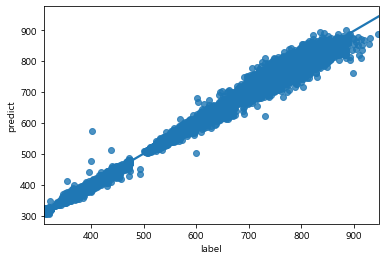

In [61]:
sns.regplot(x = 'label', y = 'predict', data = final_result)

[Text(0.5, 1.0, 'Feature Importance (split)'),
 Text(0.5, 0, 'Feature Importance'),
 Text(0, 0.5, 'Features')]

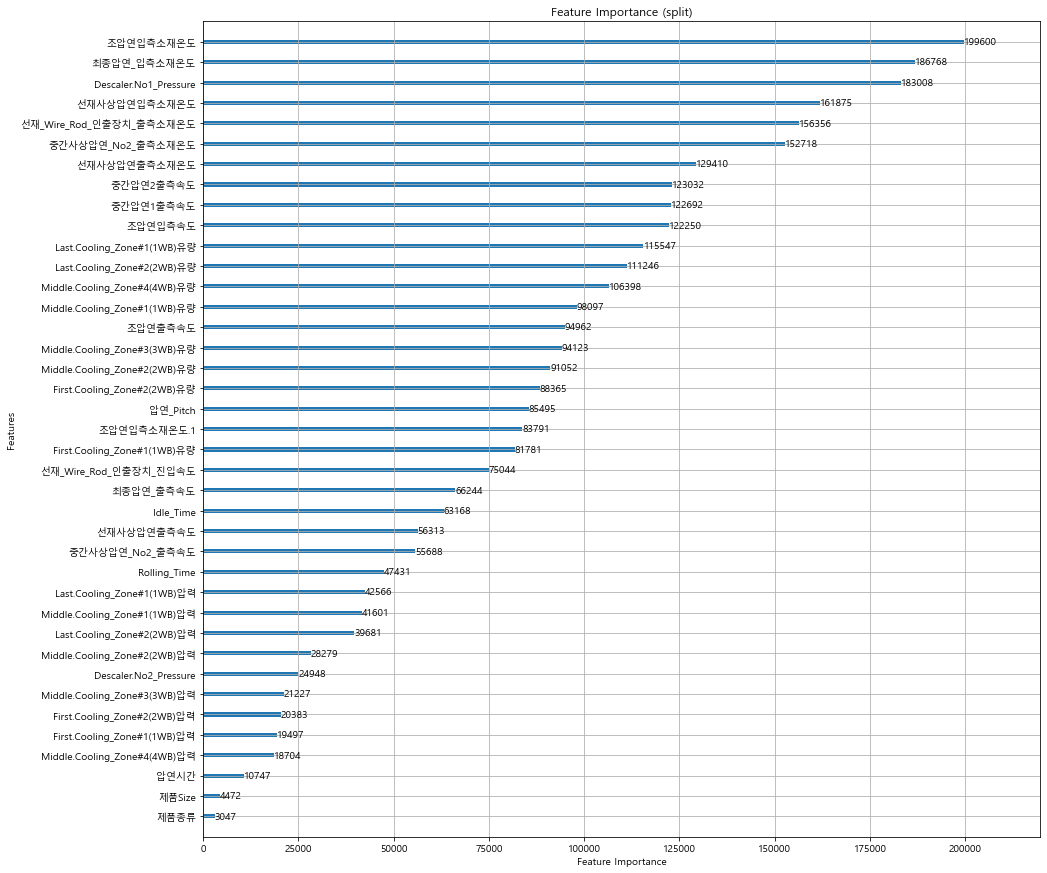

In [62]:
ax = lgb.plot_importance(lgbfit, max_num_features=len(data.columns), importance_type='split', figsize=(15,15))
ax.set(title=f'Feature Importance (split)',
	xlabel='Feature Importance',
	ylabel='Features')

[Text(0.5, 1.0, 'Feature Importance (gain)'),
 Text(0.5, 0, 'Feature Importance'),
 Text(0, 0.5, 'Features')]

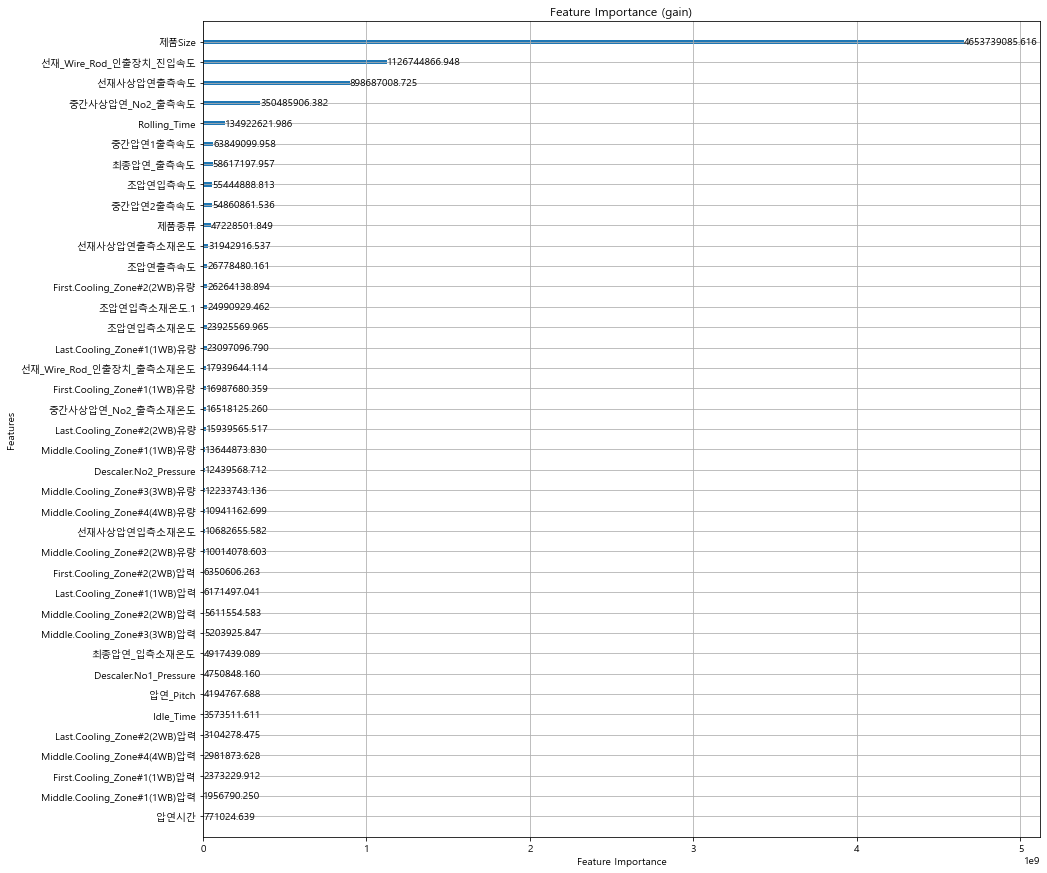

In [63]:
ax = lgb.plot_importance(lgbfit, max_num_features=len(data.columns), importance_type='gain', figsize=(15,15))
ax.set(title=f'Feature Importance (gain)',
	xlabel='Feature Importance',
	ylabel='Features')

In [64]:
import shap

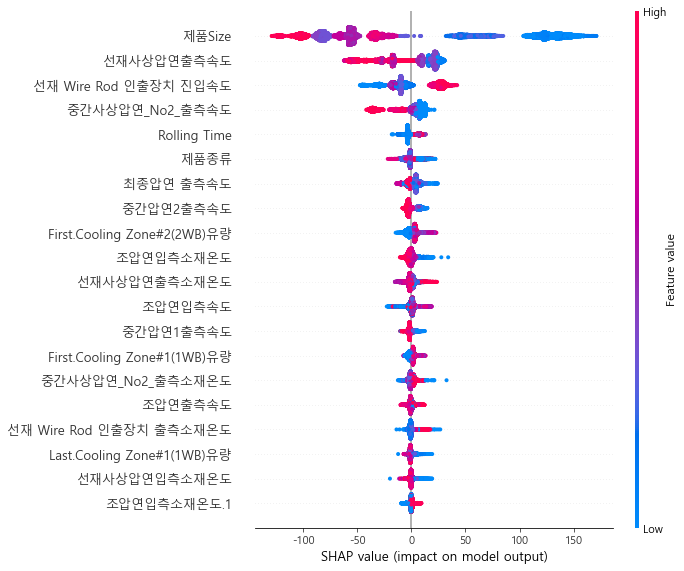

In [66]:
shap.initjs()
explainer = shap.TreeExplainer(lgbfit)
shap_values = explainer.shap_values(test_x)
fig = shap.summary_plot(shap_values, test_x)

In [71]:
len(shap_values)

20094